### Amazon Book Reviews: Clustering and genre selection from title & description

The original dataset has ~9 million reviews: http://jmcauley.ucsd.edu/data/amazon/. The metadata for book review looks like following:

{
  "asin": "0000031852",
  "title": "Girls Ballet Tutu Zebra Hot Pink",
  "price": 3.17,
  "imUrl": "http://ecx.images-amazon.com/images/I/51fAmVkTbyL._SY300_.jpg",
  "related":
  {
    "also_bought": ["B00JHONN1S", "B002BZX8Z6", "B00D2K1M3O", "0000031909", "B00613WDTQ", "B00D0WDS9A", "B00D0GCI8S", "0000031895", "B003AVKOP2", "B003AVEU6G", "B003IEDM9Q", "B002R0FA24", "B00D23MC6W", "B00D2K0PA0", "B00538F5OK", "B00CEV86I6", "B002R0FABA", "B00D10CLVW", "B003AVNY6I", "B002GZGI4E", "B001T9NUFS", "B002R0F7FE", "B00E1YRI4C", "B008UBQZKU", "B00D103F8U", "B007R2RM8W"],
    "also_viewed": ["B002BZX8Z6", "B00JHONN1S", "B008F0SU0Y", "B00D23MC6W", "B00AFDOPDA", "B00E1YRI4C", "B002GZGI4E", "B003AVKOP2", "B00D9C1WBM", "B00CEV8366", "B00CEUX0D8", "B0079ME3KU", "B00CEUWY8K", "B004FOEEHC", "0000031895", "B00BC4GY9Y", "B003XRKA7A", "B00K18LKX2", "B00EM7KAG6", "B00AMQ17JA", "B00D9C32NI", "B002C3Y6WG", "B00JLL4L5Y", "B003AVNY6I", "B008UBQZKU", "B00D0WDS9A", "B00613WDTQ", "B00538F5OK", "B005C4Y4F6", "B004LHZ1NY", "B00CPHX76U", "B00CEUWUZC", "B00IJVASUE", "B00GOR07RE", "B00J2GTM0W", "B00JHNSNSM", "B003IEDM9Q", "B00CYBU84G", "B008VV8NSQ", "B00CYBULSO", "B00I2UHSZA", "B005F50FXC", "B007LCQI3S", "B00DP68AVW", "B009RXWNSI", "B003AVEU6G", "B00HSOJB9M", "B00EHAGZNA", "B0046W9T8C", "B00E79VW6Q", "B00D10CLVW", "B00B0AVO54", "B00E95LC8Q", "B00GOR92SO", "B007ZN5Y56", "B00AL2569W", "B00B608000", "B008F0SMUC", "B00BFXLZ8M"],
    "bought_together": ["B002BZX8Z6"]
  },
  "salesRank": {"Toys & Games": 211836},
  "brand": "Coxlures",
  "categories": [["Sports & Outdoors", "Other Sports", "Dance"]]
}


I have cleaned the metadata to obtain title, rank and description. Note that the book review does not have a genre column and so I"ll have to extract it from title/description. 

In [204]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [208]:
df = pd.read_csv("books_title_desc_rank_cleaned.csv")

In [209]:
df = df.drop("Unnamed: 0", axis = 1)
df.head(1)

,asin,title,description,rank
0,0001048791,"The Crucible: Performed by Stuart Pankin, Jerome Dempsey &amp; Cast",NaN,6334800.0


#### Let's work with 10,000 best selling books

In [210]:
df1 = df.sort_values(by = 'rank')[:10000]
df1.head(2)

,asin,title,description,rank
81799,014241543X,If I Stay,"An Interview with Gayle FormanQ: You started your career as a journalist and your first book is a travelogue about going around the world. Is YA literature a departure for you?Gayle Forman: Actually, it&#x2019;s more of a homecoming. My first writing job was at Seventeen, where I spent five years on staff and as a contributor reporting the magazine&#x2019;s social-issues stories. I loved writing for teens then because&#x2014;contrary to popular opinion&#x2014;they really care about serious issues (from child soldiers in Africa to kids embroiled in the drug war here) and the engage in their reading with such passion. So, now that I&#x2019;m writing young-adult literature, it feels like I&#x2019;ve come full circle.Q: This book explores some serious themes. Why is this a book for kids and not adults?GF: It&#x2019;s a book for kids precisely because it explores serious themes. Teenagers are grappling with choices about life and love as much as adults, so why shouldn&#x2019;t their reading reflect that? I don&#x2019;t set out to write YA. It just seems like I&#x2019;m drawn to stories about young people. That said, I think If I Stay is for adults, too. I love the idea of teens reading this book and then handing it off to their parents.Q: Many key characters are serious musicians, and songs are referenced throughout the book. Are you a musician?GF: No. Except for piano lessons when I was a kid and a brief spate of guitar playing in my teens, I&#x2019;ve never played an instrument. I am, however, a huge music fan. And my husband is a musician; he was playing in a punk band when we met, so I&#x2019;ve spent a lot of my life ensconced in that scene. I seem drawn to writing about musicians, though I&#x2019;ve never been all that interested in the cello until Mia popped into my head.Q: What inspired you to write this book?GF: Music. Oregon. People I have loved. And unfortunately, the book is inspired by a real-life tragedy that happened several years ago.Q: This is a book about death, but it&#x2019;s not depressing. Why is that?GF: Maybe because it&#x2019;s really about the power of love&#x2014;of family, friends, music&#x2014;and therefore it ultimately affirms life.--This text refers to an out of print or unavailable edition of this title.",1.0
502904,0736430512,Frozen Little Golden Book (Disney Frozen),NaN,3.0


In [211]:
df1.title.isnull().values.sum() # number of null values in title

0

Next we create some functions for text analysis (as we did before). Some of these codes are from http://brandonrose.org/clustering

In [213]:
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
from sklearn.feature_extraction import text
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA, KernelPCA

In [214]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [215]:
add_text = ["book"]
my_stop_words = text.ENGLISH_STOP_WORDS.union(add_text)
stemmer = SnowballStemmer("english")

In [216]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in df1.title:
    allwords_stemmed = tokenize_and_stem(i) 
    totalvocab_stemmed.extend(allwords_stemmed) 

    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
vocab_frame = vocab_frame.drop(add_text)
vocab_frame.head()

,words
if,if
i,i
stay,stay
frozen,frozen
littl,little


In [217]:
vocab_frame.shape

(85970, 1)

In [218]:
tfidf_vectorizer = TfidfVectorizer(max_df=1.0, max_features=5000,
                                     min_df=0.0, stop_words=set(my_stop_words),
                                     use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,1))

In [219]:
%time tfidf_matrix = tfidf_vectorizer.fit_transform(df1.title) 

Wall time: 4 s


In [220]:
terms = tfidf_vectorizer.get_feature_names()
terms[:10]

[u"'d",
 u"'i",
 u"'m",
 u"'n",
 u"'s",
 u'*5th',
 u'*habitu',
 u'*irrat',
 u'*negat',
 u'*project']

We can get a vocabulary list from the tfidf vectorizer and make a list 

In [221]:
tfidf_vocab = tfidf_vectorizer.vocabulary_
tfidf_vocab = pd.DataFrame(tfidf_vocab.items(), columns = ['term', '#'])
#tfidf_vocab.sort_values(by = 'freq', ascending = False)[:10]
tfidf_vocab[:10]

,term,#
0,bad-boy,402
1,yellow,4940
2,educ,1406
3,self-studi,3939
4,lore,2544
5,lord,2543
6,digit,1244
7,x-men,4934
8,/sup,18
9,prize,3342


We can calculate phrase scores 

In [222]:
dense = tfidf_matrix.todense()
len(dense[0].tolist()[0])
review_dense = dense[0].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(review_dense)), review_dense)]
len(phrase_scores)

5000

In [223]:
top_numbers = 100
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
top_words = []
top_score = []
top =[]
for phrase, score in [(terms[word_id], score) 
    for (word_id, score) in sorted_phrase_scores][:top_numbers]:
        #print('{0: <20} {1}'.format(phrase, round(score,5)))
        top.append({'Feature_Name':phrase, 'Score':score})
        top_words.append(phrase)
        top_score.append(int(score*100))

pd.DataFrame(top)[:10]

,Feature_Name,Score
0,stay,1.0
1,'d,0.0
2,'i,0.0
3,'m,0.0
4,'n,0.0
5,'s,0.0
6,*5th,0.0
7,*habitu,0.0
8,*irrat,0.0
9,*negat,0.0


We can do a PCA

In [224]:
%time pca = PCA(n_components=2).fit(dense)
data2D = pca.transform(dense)

Wall time: 5.62 s


In [225]:
dataframe1 = pd.DataFrame(dict(x=data2D[:,0], y=data2D[:,1], asin = df1.asin, title=df1.title, rank=df1['rank']))
dataframe1.head(3)

,asin,rank,title,x,y
81799,014241543X,1.0,If I Stay,0.002542,-0.021302
502904,0736430512,3.0,Frozen Little Golden Book (Disney Frozen),0.003389,-0.034729
145029,0307588378,4.0,Gone Girl: A Novel,0.410178,0.041957


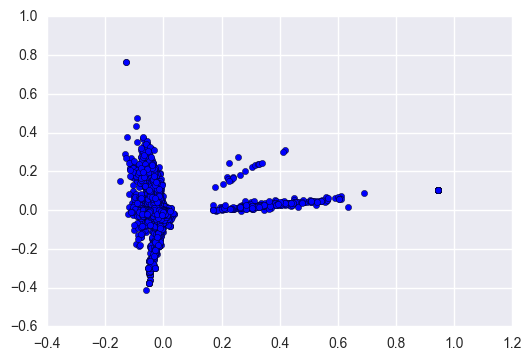

In [226]:
plt.scatter(dataframe1.x, dataframe1.y)

#### Optimal number of clusters

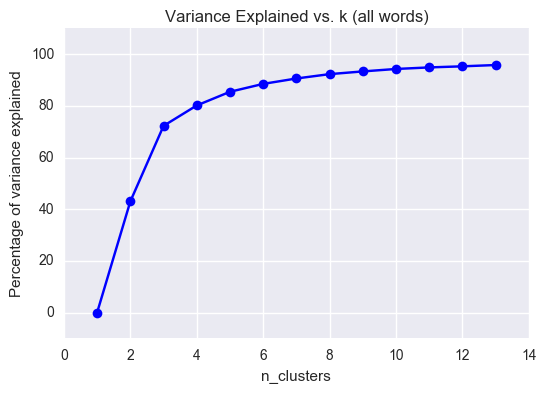

In [227]:
import numpy as np
from scipy.spatial.distance import cdist, pdist
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

# Determine your k range
k_range = range(1,14)

# Fit the kmeans model for each n_clusters = k
k_means_var = [KMeans(n_clusters=k).fit(data2D) for k in k_range]

# Pull out the cluster centers for each model
centroids = [X.cluster_centers_ for X in k_means_var]

# Calculate the Euclidean distance from 
# each point to each cluster center
k_euclid = [cdist(data2D, cent, 'euclidean') for cent in centroids]
dist = [np.min(ke,axis=1) for ke in k_euclid]

# Total within-cluster sum of squares
wcss = [sum(d**2) for d in dist]

# The total sum of squares
tss = sum(pdist(data2D)**2)/data2D.shape[0]

# The between-cluster sum of squares
bss = tss - wcss

# elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(k_range, bss/tss*100, 'bo-')
ax.set_ylim((-10,110))
#plt.grid(True)
plt.xlabel('n_clusters')
plt.ylabel('Percentage of variance explained')
plt.title('Variance Explained vs. k (all words)')

In [310]:
n_clusters = 6 
k_means = KMeans(n_clusters = n_clusters, n_init = 50)
dataframe1 ['clusterID'] = k_means.fit_predict(data2D)

In [311]:
dataframe1.head()

,asin,rank,title,x,y,clusterID
81799,014241543X,1.0,If I Stay,0.002542,-0.021302,0
502904,0736430512,3.0,Frozen Little Golden Book (Disney Frozen),0.003389,-0.034729,0
145029,0307588378,4.0,Gone Girl: A Novel,0.410178,0.041957,4
31644,0062345214,6.0,Four: A Divergent Collection (Divergent Series),0.001952,-0.031536,0
1203889,1465414053,9.0,Ultimate Sticker Book: Frozen (Ultimate Sticker Books),-0.005275,-0.021283,0


In [312]:
centroids = k_means.cluster_centers_

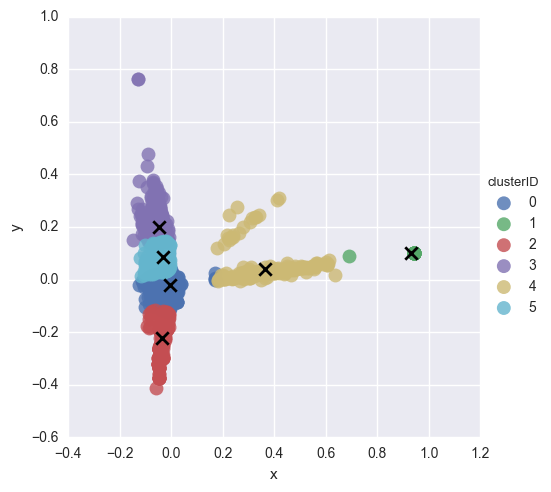

In [313]:
sns.lmplot(x = 'x', y = 'y', hue = "clusterID", data=dataframe1, fit_reg= False, scatter_kws={"s": 100}) 
plt.scatter(centroids[:, 0], centroids[:, 1], marker = "x", color = 'k', s=80, linewidths=2)

In [314]:
from sklearn.cluster import KMeans
from sklearn.externals import joblib
from __future__ import print_function

num_clusters = 6 
km = KMeans(n_clusters=num_clusters, random_state= 123, n_init=20)
print ("K-means fit:") 
%time km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

joblib.dump(km,  'doc_cluster.pkl')
km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()
df1['clusterName'] = clusters
print()
print ("Number of items in each cluster:")
print (df1.clusterName.value_counts())
df1 = df1.set_index('clusterName')
print()
print("Top terms per cluster:")
print()
    
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
        
for i in range(num_clusters):
    print("Cluster %d top words:" % i, end='')

    for ind in order_centroids[i, :5]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print() #add whitespace
    print() #add whitespace

    
    print("Cluster %d books:" % i, end='')
    for book in df1.ix[i]['title'][:20]:
        print(' %s,' % book, end='')
    print() #add whitespace
    print() #add whitespace

print()
print()

K-means fit:
Wall time: 11.2 s

Number of items in each cluster:
5    7069
0    1017
1    901 
2    720 
3    216 
4    77  
Name: clusterName, dtype: int64

Top terms per cluster:

Cluster 0 top words: 's, guide, world, god, children,

Cluster 0 books: Heaven is for Real: A Little Boy's Astounding Story of His Trip to Heaven and Back, Orange Is the New Black: My Year in a Women's Prison, Grain Brain: The Surprising Truth about Wheat, Carbs,  and Sugar--Your Brain's Silent Killers, Written in My Own Heart's Blood: A Novel (Outlander), The Husband's Secret, One Nation: What We Can All Do to Save America's Future, Proof of Heaven: A Neurosurgeon's Journey into the Afterlife, Eleanor &amp; Park (Ira Children's Book Awards. Young Adult), Where Is Baby's Belly Button? A Lift-the-Flap Book, A Wrinkle in Time (Madeleine L'Engle's Time Quintet), A People's History of the United States: 1492 to Present, The Whole-Brain Child: 12 Revolutionary Strategies to Nurture Your Child's Developing Mind, 

So we classified 20 books for each cluster based on their title. We see that cluster # 5 contains 7069 elements. We can do another clustering of the cluster 5 books itself. We also see that there are some words like first, 2nd, third etc. We are going to stop these wrods and make a function which would give us a PCA plot, books and words for each clusters.

In [315]:
df1 = df1.reset_index()

In [316]:
df2 = df1[df1.clusterName == 5]

In [317]:
add_text = ["book", "'s", "1st", "first", "second", "third", "2nd", "3rd", "4th", "5th", "read", "'d", "dover", "edition"]
#add_text = ["'s"]
my_stop_words = text.ENGLISH_STOP_WORDS.union(add_text)
stemmer = SnowballStemmer("english")
from __future__ import print_function

def cluster_books_title (dataframe, num_clusters, n_words):
    
    from sklearn.cluster import KMeans
    from sklearn.externals import joblib
    
    
    totalvocab_stemmed = []
    totalvocab_tokenized = []
    for i in dataframe.title:
        allwords_stemmed = tokenize_and_stem(i) 
        totalvocab_stemmed.extend(allwords_stemmed) 

        allwords_tokenized = tokenize_only(i)
        totalvocab_tokenized.extend(allwords_tokenized)

    vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
    
    tfidf_vectorizer_cluster = TfidfVectorizer(max_df=1.0, max_features=5000,
                                         min_df=0.0, 
                                            stop_words=set(my_stop_words),
                                         use_idf=True, 
                                tokenizer=tokenize_and_stem, ngram_range=(1, 1))

    tfidf_matrix_cluster = tfidf_vectorizer_cluster.fit_transform(dataframe.title) 
    
    terms = tfidf_vectorizer_cluster.get_feature_names()
   
    tfidf_matrix_cluster_dense = tfidf_matrix_cluster.todense()
    
    pca = PCA(n_components=2).fit(tfidf_matrix_cluster_dense)
    data2D = pca.transform(tfidf_matrix_cluster_dense)
    
    dataframe1 = pd.DataFrame(dict(x=data2D[:,0], y=data2D[:,1], asin = dataframe.asin, title=dataframe.title, rank=dataframe['rank']))
    
    km = KMeans(n_clusters=num_clusters, random_state= 123, n_init=20)
   
    
    dataframe1 ['clusterID'] = km.fit_predict(data2D)
    
    centroids = km.cluster_centers_
    sns.lmplot(x = 'x', y = 'y', hue = "clusterID", data=dataframe1, fit_reg= False, scatter_kws={"s": 100}) 
    plt.scatter(centroids[:, 0], centroids[:, 1], marker = "x", color = 'k', s=80, linewidths=2)
    plt.title ("2D PCA")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()
    
    km.fit(tfidf_matrix_cluster)
    clusters = km.labels_.tolist()

    joblib.dump(km,  'doc_cluster.pkl')
    km = joblib.load('doc_cluster.pkl')
    clusters = km.labels_.tolist()
    dataframe['clusterName'] = clusters
    print()
    print ("Number of items in each cluster:")
    print (dataframe.clusterName.value_counts())
    dataframe = dataframe.set_index('clusterName')
    print()
    print("Top terms per cluster:")
    print()

    #sort cluster centers by proximity to centroid
    order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

    for i in range(num_clusters):
        print("Cluster %d top words:" % i, end='')

        for ind in order_centroids[i, :n_words]: 
            print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
        print() #add whitespace
        print() #add whitespace

       
        print("Cluster %d books:" % i, end='')
        for book in dataframe.ix[i]['title'][:20]:
            print(' %s,' % book, end='')
        print() #add whitespace
        print() #add whitespace

    print()
    print()

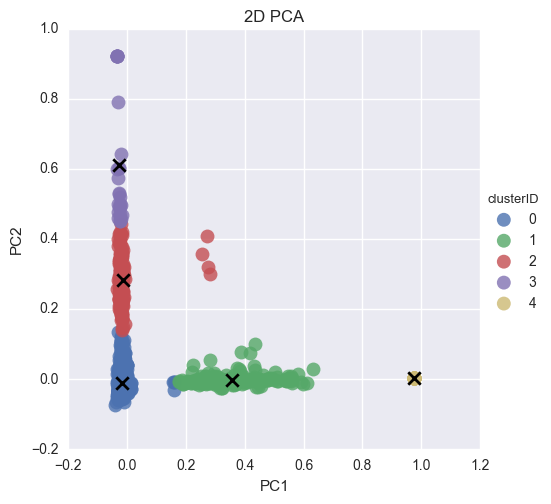


Number of items in each cluster:
0    6382
1    255 
3    242 
2    107 
4    83  
Name: clusterName, dtype: int64

Top terms per cluster:

Cluster 0 top words: amp, story, love, new, world,

Cluster 0 books: If I Stay, Four: A Divergent Collection (Divergent Series), Looking for Alaska, Fifty Shades of Grey: Book One of the Fifty Shades Trilogy, Fifty Shades Trilogy: Fifty Shades of Grey, Fifty Shades Darker, Fifty Shades Freed 3-volume Boxed Set, Business, The Alchemist, StrengthsFinder 2.0, America: Imagine a World without Her, The Book Thief, The 5 Love Languages: The Secret to Love That Lasts, George R. R. Martin's A Game of Thrones 5-Book Boxed Set (Song of Ice and Fire series): A Game of Thrones, A Clash of Kings, A Storm of Swords, A Feast for Crows, and A Dance with Dragons, Insurgent (Divergent, Book 2) (Divergent Series), The Very Hungry Caterpillar, The Day the Crayons Quit, Outliers: The Story of Success, The Going-To-Bed Book, Divergent, How to Win Friends &amp; Influenc

C:\Users\Bis\Anaconda2\lib\site-packages\ipykernel\__main__.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [318]:
cluster_books_title(df2, 5, 5)

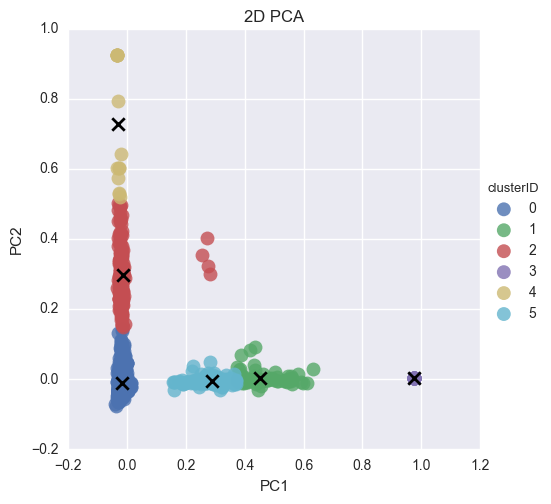


Number of items in each cluster:
1    6210
5    254 
4    237 
2    192 
0    116 
3    60  
Name: clusterName, dtype: int64

Top terms per cluster:

Cluster 0 top words: animal, map, nation, encyclopedia, geographic, character,

Cluster 0 books: My Big Animal Book (My Big Board Books), Rand McNally World Folded Wall Map (M Series Map of the World), Animals (Baby Touch and Feel), Spirit Animals: Book 4: Fire and Ice, Streetwise Paris Map - Laminated City Center Street Map of Paris, France, Creative Haven Art Nouveau Animal Designs Coloring Book (Creative Haven Coloring Books), America the Beautiful: Rediscovering What Made This Nation Great, The Soul of All Living Creatures: What Animals Can Teach Us About Being Human, Rand Mcnally Us Wall Map (M Series U.S.A. Wall Maps) 50&quot;x32&quot;, Streetwise Manhattan Map - Laminated City Street Map of Manhattan, New York - Folding pocket size travel map with subway map, bus map, Rand McNally U.S.A Wall Map, Marvel Encyclopedia, Animal Farm a

C:\Users\Bis\Anaconda2\lib\site-packages\ipykernel\__main__.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [319]:
cluster_books_title(df2, 6, 6) # can also do six clusters

So, we see that subclustering of a cluster still gives some useful genres and associated books. we can do another subclustering.

In [320]:
len(df2[df2.clusterName == 1])

6210

In [321]:
df3 = df2[df2.clusterName == 1]

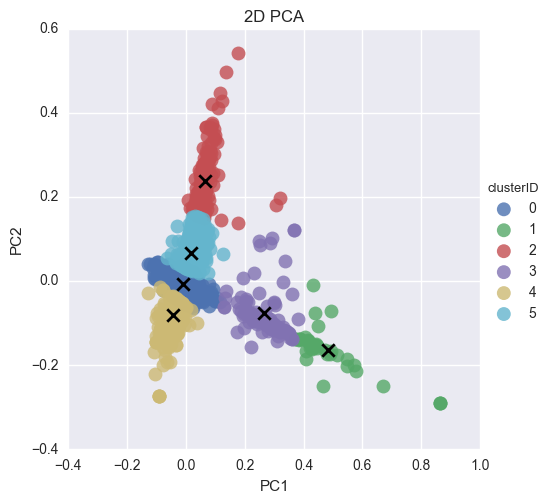


Number of items in each cluster:
1    4962
0    457 
5    272 
2    242 
3    145 
4    132 
Name: clusterName, dtype: int64

Top terms per cluster:

Cluster 0 top words: love, new, practice, nursing, workbook,

Cluster 0 books: The 5 Love Languages: The Secret to Love That Lasts, GRE&reg; Premier 2015 with 6 Practice Tests: Book + DVD + Online + Mobile (Kaplan Test Prep), Mindset: The New Psychology of Success, Guess How Much I Love You, The Body Book: The Law of Hunger, the Science of Strength, and Other Ways to Love Your Amazing Body, Dragons Love Tacos, Big Preschool Workbook, Humans of New York, Practical Paleo: A Customized Approach to Health and a Whole-Foods Lifestyle, 5 lb. Book of GRE Practice Problems, Kaplan GMAT Premier 2015 with 6 Practice Tests: Book + DVD + Online + Mobile (Kaplan Test Prep), My New Baby, Pete the Cat: I Love My White Shoes, The New Baby, A Return to Love: Reflections on the Principles of &quot;A Course in Miracles&quot;, The 5 Love Languages of Childr

C:\Users\Bis\Anaconda2\lib\site-packages\ipykernel\__main__.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [322]:
cluster_books_title(df3,6, 5)

We can increase the # of clusters in the original dataset (df1, 10000 books) to get more genres. 

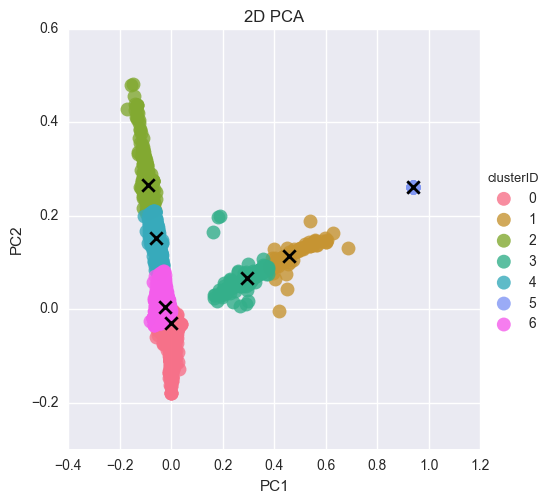


Number of items in each cluster:
5    7483
4    810 
3    643 
0    449 
1    280 
2    247 
6    88  
Name: clusterName, dtype: int64

Top terms per cluster:

Cluster 0 top words: amp, cards, flash, guide, edition,

Cluster 0 books: How to Win Friends &amp; Influence People, Dungeons &amp; Dragons Starter Set: Fantasy Roleplaying Fundamentals (D&amp;D Boxed Game), Against All Grain: Delectable Paleo Recipes to Eat Well &amp; Feel Great, Eleanor &amp; Park (Ira Children's Book Awards. Young Adult), Superfood Smoothies: 100 Delicious, Energizing &amp; Nutrient-dense Recipes, The Knot Ultimate Wedding Planner &amp; Organizer [binder edition]: Worksheets, Checklists, Etiquette, Calendars, and Answers to Frequently Asked Questions, Good Night, Thomas (Thomas &amp; Friends) (Glow-in-the-Dark Board Book), The Dialectical Behavior Therapy Skills Workbook: Practical DBT Exercises for Learning Mindfulness, Interpersonal Effectiveness, Emotion Regulation &amp; ... Tolerance (New Harbinger Self-

In [323]:
cluster_books_title(df1,7, 5)

As we can see for 7 clusters, two centroids are close to each other.

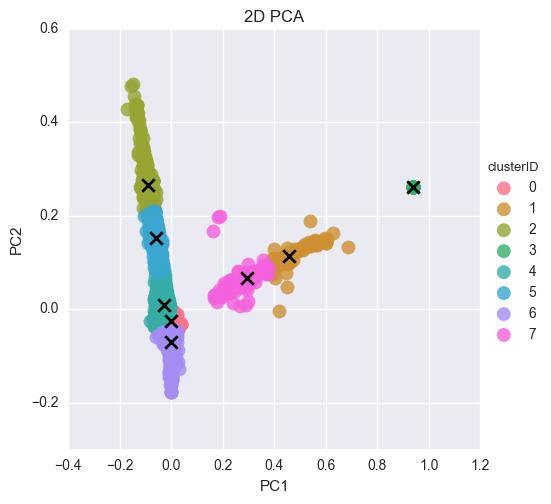


Number of items in each cluster:
7    7335
3    837 
2    676 
4    276 
5    245 
0    234 
1    202 
6    195 
Name: clusterName, dtype: int64

Top terms per cluster:

Cluster 0 top words: war, workbooks, cards, star, flash,

Cluster 0 books: Act of War: A Thriller, Big Preschool Workbook, Flash Boys, The Dialectical Behavior Therapy Skills Workbook: Practical DBT Exercises for Learning Mindfulness, Interpersonal Effectiveness, Emotion Regulation &amp; ... Tolerance (New Harbinger Self-Help Workbook), Big Kindergarten Workbook, Barron's SAT Vocabulary Flash Cards, The Lemonade War (The Lemonade War Series), Brain Quest Workbook: Kindergarten, War of the Whales: A True Story, My Book Of Numbers 1-30 (Kumon Workbooks), My First Book Of Tracing (Kumon Workbooks), First Words Flash Cards (Brighter Child Flash Cards), The Anxiety and Phobia Workbook, Complete Color Coded Flash Cards for All Beginning Music Students, William Shakespeare's Star Wars, Brain Quest Workbook: Pre-K, The Walkin

In [324]:
cluster_books_title(df1,8, 5)

### LDA and NMF for topic extraction

In [105]:
#strip any proper names from a text...unfortunately right now this is yanking the first word from a sentence too.
import string
def strip_proppers(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()

In [106]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

In [285]:
df4 = df.sort_values(by = 'rank')[:5000] # top 100 books

In [286]:
from gensim import corpora, models, similarities 

#remove proper names
%time preprocess = [strip_proppers(doc) for doc in df4.title]

#tokenize
%time tokenized_text = [tokenize_and_stem(text) for text in preprocess]

#remove stop words
%time texts = [[word for word in text if word not in my_stop_words] for text in tokenized_text]

Wall time: 1 s
Wall time: 648 ms
Wall time: 7 ms


In [287]:
#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=1, no_above=0.8)

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in texts]

In [288]:

%time lda = models.LdaModel(corpus, num_topics=20, id2word=dictionary, update_every=5, chunksize=100, passes=20)

Wall time: 47 s


In [289]:
lda.show_topics()

[(6,
  u'0.207*"s" + 0.165*"eacut" + 0.086*"mon" + 0.061*"board" + 0.029*"dex" + 0.026*"s/espa" + 0.026*"espa" + 0.026*"ol" + 0.026*"ol/ingl" + 0.026*"ingl"'),
 (3,
  u'0.546*"reg" + 0.066*"13th" + 0.036*"build" + 0.031*"-and" + 0.001*"5e" + 0.001*"amp" + 0.001*"s" + 0.001*"6e" + 0.001*"wrap" + 0.001*"8-copi"'),
 (18,
  u'0.217*"9th" + 0.109*"ve" + 0.072*"y" + 0.035*"vocabulario" + 0.035*"gramatica" + 0.035*"todo" + 0.033*"14th" + 0.023*"noch" + 0.014*"piedra" + 0.014*"filosof"'),
 (15,
  u'0.264*"ll" + 0.080*"25th" + 0.043*"iexcl" + 0.043*"35th" + 0.043*"poem" + 0.043*"note" + 0.043*"love" + 0.038*"tale" + 0.015*"vs." + 0.001*"paperback"'),
 (10,
  u'0.106*"21st" + 0.100*"9e" + 0.062*"day" + 0.049*"gene" + 0.042*"health" + 0.035*"plan" + 0.035*"action" + 0.035*"step-by-step" + 0.035*"reprogram" + 0.015*"expos"'),
 (8,
  u'0.110*"7th" + 0.094*"ntild" + 0.061*"new" + 0.052*"o" + 0.038*"cielo" + 0.034*"pequ" + 0.032*"al" + 0.031*"10e" + 0.028*"nivel" + 0.028*"por"'),
 (1,
  u'0.320*"edit

In [78]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [290]:
#vocab = ["romance", "mystery", "drama", "fiction", "teen", "teens", "biography", "story", "tale", "animal", "family", "fun", 
        # "horror", "comedy", "action", "classic", "crime", "fantasy", "humor", "children", "kid", "families","conceptual",
        #"innovation", "traumas", "style", "fashion", "social", "issues", "collection", "science", "period", "photographs",
        #"historical", "murder", "suspenseful", "suspence", "inspirational", "graphic", "instructions", "thriller", "adventure",
        #"western", "textbook", "legal", "action-packed", "career", "information", "contemporary",
        #"mature", "adult", "military", "marine", "cops", "agriculture", "history", "photography","academic", "academy",
        #"geography", "myth", "mythology", "paranormal", "essay", "self-help", "memoir", "autobiography", 
         #"romantic", "fairy tale", "science fiction", "religion", "jesus"]

tfidf_vectorizer_top = TfidfVectorizer(max_df=1.0, max_features=5000,
                                         min_df=0.0, 
                                            stop_words=set(my_stop_words),
                                         use_idf=True, 
                                tokenizer=tokenize_and_stem, ngram_range=(1, 1))

tfidf_matrix_top = tfidf_vectorizer_top.fit_transform(df4.title) 
    
terms_top = tfidf_vectorizer_top.get_feature_names()
   
tfidf_matrix_top_dense = tfidf_matrix_top.todense()

In [291]:
n_samples = 2000
n_features = 1000
n_topics = 10
n_top_words = 10


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [292]:
lda1 = LatentDirichletAllocation(n_topics=n_topics, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

lda1.fit(tfidf_matrix_top)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method=u'online', learning_offset=50.0,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_jobs=1, n_topics=10, perp_tol=0.1, random_state=0,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

In [293]:
print_top_words(lda1, terms_top, n_top_words)

Topic #0:
passport crow yoga harri level fairi ice lost potter door
Topic #1:
kit bear societi mymathlab field eastern audubon north christian berenstain
Topic #2:
novel hous vol trilog say life year fall richard r
Topic #3:
workbook war poni math world walk grade star savannah tour
Topic #4:
spectrum dog dictionari grade medic heaven tree visual merriam-webst georg
Topic #5:
edit access test guid grade dummi activ set card box
Topic #6:
girl p.s level adventur letter chronicl tale moon thrift novel
Topic #7:
guid edit stori littl life big recip amp bibl live
Topic #8:
titan train attack card flash cat love quot dragon ap
Topic #9:
bird america eleph wood john rainbow glass fish piggi sister



In [294]:
from sklearn.decomposition import NMF

In [296]:
nmf = NMF(n_components=n_topics, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf_matrix_top)

In [297]:
print_top_words(nmf, terms_top, n_top_words)

Topic #0:
edit thrift revis student barron anniversari biolog spanish languag chemistri
Topic #1:
novel graphic home power life hous wife citi light survivalist
Topic #2:
grade spectrum math prep workbook core summer bridg common kumon
Topic #3:
littl activ sticker golden critter disney red just princess crossword
Topic #4:
guid studi offici nurs essenti ultim field amp write refer
Topic #5:
test practic prep kaplan prepar crack onlin colleg sat review
Topic #6:
love languag secret letter men guess relationship life parent relentless
Topic #7:
big kid nation geograph reader anim dinosaur whi board time
Topic #8:
stori true bibl children world best heaven outlier god church
Topic #9:
workbook war star art kumon kindergarten math abc grade quest



#### Clustering of books when we provide the genre list in tfidf vocabulary

In [302]:
df5 = df1.sample(n = 2000) 
df5 = df5.drop("clusterName", axis = 1)
df5 = df5.reset_index()
df5 = df5.drop("clusterName", axis = 1)
df5 = df5.dropna()
df5.head(1)

,asin,title,description,rank
0,1592407552,"Showtime: Magic, Kareem, Riley, and the Los Angeles Lakers Dynasty of the 1980s","Some books about sports (think George Plimpton or David Halberstam) are the equivalent of literary fiction; some (say, John Feinstein) compare favorably with serious nonfiction about other subjects. Showtime, by the author of Sweetness: The Enigmatic Life of Walter Payton (2011), is more on the order of a celebrity bio. It is gossipy, at times sensationally so (particularly in regard to drug use and sex), and sometimes sophomoric (and cruelly demeaning of lesser players), but it imparts hard-won inside knowledge, and it is certainly entertaining. Many of its individual subjects are true celebrities&#x2014;the ebullient and charismatic, though problematic, Earvin Magic Johnson; the moody (and far stronger words are used) Kareem Abdul-Jabbar; coach Pat Riley; and even owner Jerry Buss&#x2014;and with outsize egos to match. But, though not gelling immediately, the L.A. Lakers of the 1980s became, by mid-decade, an extraordinary basketball team, perhaps the best ever, and if their flamboyant style on and off the court belied their discipline and frequent sheer brilliance, it merits the enthusiastic and wide-ranging treatment that Pearlman gives it. --Mark Levine",10982.0


In [303]:
add_text = ["book", "'s", "1st", "first", "second", "third", "2nd", "3rd", "4th", "5th", "read", "'d", "dover", "edition"]
#add_text = ["'s"]

vocab = ["romance", "mystery", "drama", "fiction", "teen", "teens", "biography", "story", "tale", "animal", "family", "fun", 
         "horror", "comedy", "action", "classic", "crime", "fantasy", "humor", "children", "kid", "families","conceptual",
        "innovation", "traumas", "style", "fashion", "social", "issues", "collection", "science", "period", "photographs",
        "historical", "murder", "suspenseful", "suspence", "inspirational", "graphic", "instructions", "thriller", "adventure",
        "western", "textbook", "legal", "action-packed", "career", "information", "contemporary",
        "mature", "adult", "military", "marine", "cops", "agriculture", "history", "photography","academic", "academy",
        "geography", "myth", "mythology", "paranormal", "essay", "self-help", "memoir", "autobiography", 
         "romantic", "fairy tale", "science fiction", "religion", "jesus"]
from sklearn.feature_extraction import text
my_stop_words = text.ENGLISH_STOP_WORDS.union(add_text)
stemmer = SnowballStemmer("english")
from __future__ import print_function

def cluster_books_description (dataframe, num_clusters, n_words):
    
    from sklearn.cluster import KMeans
    from sklearn.externals import joblib
    
    
    totalvocab_stemmed = []
    totalvocab_tokenized = []
    for i in dataframe.description:
        allwords_stemmed = tokenize_and_stem(i) 
        totalvocab_stemmed.extend(allwords_stemmed) 

        allwords_tokenized = tokenize_only(i)
        totalvocab_tokenized.extend(allwords_tokenized)

    vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
    
    tfidf_vectorizer_cluster = TfidfVectorizer(max_df=1.0, max_features=5000,
                                         min_df=0.0, 
                                            stop_words=set(my_stop_words),
                                         use_idf=True, 
                                tokenizer=tokenize_and_stem, ngram_range=(1, 1), vocabulary = vocab)

    tfidf_matrix_cluster = tfidf_vectorizer_cluster.fit_transform(dataframe.description) 
    
    terms = tfidf_vectorizer_cluster.get_feature_names()
   
    tfidf_matrix_cluster_dense = tfidf_matrix_cluster.todense()
    
    pca = PCA(n_components=2).fit(tfidf_matrix_cluster_dense)
    data2D = pca.transform(tfidf_matrix_cluster_dense)
    
    dataframe1 = pd.DataFrame(dict(x=data2D[:,0], y=data2D[:,1], asin = dataframe.asin, title=dataframe.title, rank=dataframe['rank']))
    
    km = KMeans(n_clusters=num_clusters, random_state= 123, n_init=20)
   
    
    dataframe1 ['clusterID'] = km.fit_predict(data2D)
    
    centroids = km.cluster_centers_
    sns.lmplot(x = 'x', y = 'y', hue = "clusterID", data=dataframe1, fit_reg= False, scatter_kws={"s": 100}) 
    plt.scatter(centroids[:, 0], centroids[:, 1], marker = "x", color = 'k', s=80, linewidths=2)
    plt.title ("2D PCA")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()
    
    
    print ("K-means fit:") 
    km.fit(tfidf_matrix_cluster)
    clusters = km.labels_.tolist()

    joblib.dump(km,  'doc_cluster.pkl')
    km = joblib.load('doc_cluster.pkl')
    clusters = km.labels_.tolist()
    dataframe['clusterName'] = clusters
    print()
    print ("Number of items in each cluster:")
    print (dataframe.clusterName.value_counts())
    dataframe = dataframe.set_index('clusterName')
    print()
    print("Top terms per cluster:")
    print()

    #sort cluster centers by proximity to centroid
    order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

    for i in range(num_clusters):
        print("Cluster %d top words:" % i, end='')

        for ind in order_centroids[i, :n_words]: 
            print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
        print() #add whitespace
        print() #add whitespace

       
        print("Cluster %d books:" % i, end='')
        for book in dataframe.ix[i]['title'][:20]:
            print(' %s,' % book, end='')
        print() #add whitespace
        print() #add whitespace

    print()
    print()

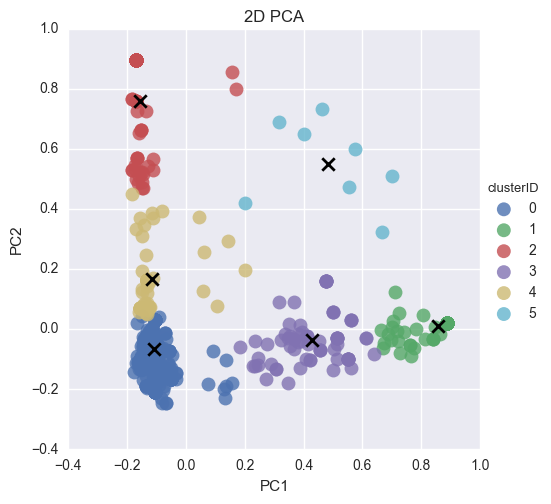

K-means fit:

Number of items in each cluster:
1    907
3    148
2    114
0    68 
5    63 
4    58 
Name: clusterName, dtype: int64

Top terms per cluster:

Cluster 0 top words: tale, humor, fiction, action, children,

Cluster 0 books: The Longest Ride, The Girl Who Came Home: A Novel of the Titanic (P.S.), Flight 232: A Story of Disaster and Survival, The Witches, Guess How Much I Love You, The Story of Babar: The Little Elephant, The Great Book of Amber: The Complete Amber Chronicles, 1-10 (Chronicles of Amber), The Story Of Ruby Bridges: Special Anniversary Edition, A Replacement Life: A Novel, Outlaw Platoon: Heroes, Renegades, Infidels, and the Brotherhood of War in Afghanistan, A Monster Calls: Inspired by an idea from Siobhan Dowd, Faraday, Maxwell, and the Electromagnetic Field: How Two Men Revolutionized Physics, On a Clear Day: Starlight\Promise Me Forever, Stuart Little, Dark Force Rising (Star Wars: The Thrawn Trilogy, Vol. 2), The Relatives Came, Mike Mulligan and More: F

In [305]:
cluster_books_description(df5, 6, 5)

In [307]:
len(df5[df5.clusterName == 1])

907

In [308]:
df6 = df5[df5.clusterName == 1]

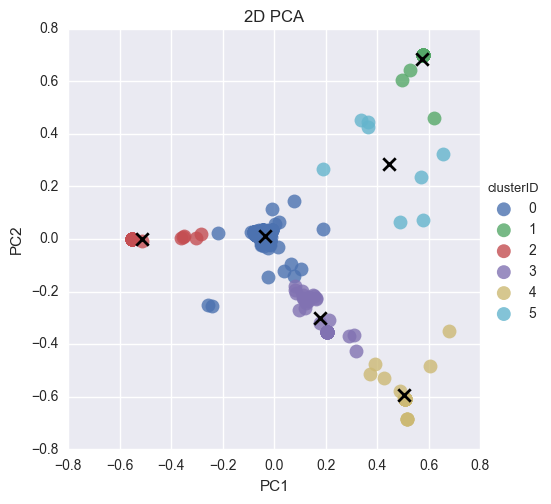

K-means fit:


C:\Users\Bis\Anaconda2\lib\site-packages\ipykernel\__main__.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Number of items in each cluster:
0    752
3    37 
1    35 
5    33 
2    29 
4    21 
Name: clusterName, dtype: int64

Top terms per cluster:

Cluster 0 top words: fiction, jesus, religion, graphically, adults,

Cluster 0 books: The Places that Scare You: A Guide to Fearlessness in Difficult Times (Shambhala Classics), The True Story of Noah's Ark (with audio CD and pull-out spread), Paul and the Faithfulness of God, Medical Assistant Exam Review (Kaplan Medical Assistant Exam Review), Buckland's Complete Book of Witchcraft (Llewellyn's Practical Magick), Pinkalicious: Soccer Star (I Can Read Book 1), Statistics for the Behavioral Sciences (Psy 200 (300) Quantitative Methods in Psychology), Pinkalicious: Crazy Hair Day, Water Dog: Revolutionary Rapid Training Method, Out of a Far Country: A Gay Son's Journey to God. A Broken Mother's Search for Hope., Leviathan: With Selected Variants from the Latin Edition of 1668, Latin American Spanish, Conversational: Learn to Speak and Understan

In [309]:
cluster_books_description(df6, 6, 5)